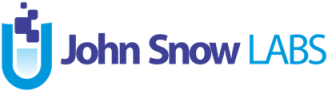

# 🚀 JohnSnowLabs Medical LLM Inference Server

### 🔄 Pulling Required Images

The necessary Docker images to run the LLM have already been pulled from
👉 [Docker Hub](https://hub.docker.com/r/johnsnowlabs/jsl-llms)

---

### 🐳 Containers Running on System Startup

The containers are configured to start automatically when the system boots.

You can verify the running containers with:

```bash
docker ps
```

You should see **two containers** running:

* **`johnsnowlabs/jsl-llms:0.11.0`** – runs the LLM service.
* **`ghcr.io/open-webui/open-webui:main`** – provides the WebUI interface to interact with the model.

---

### 📜 Viewing Container Logs

You can monitor the logs for any container using:

```bash
docker logs <container-id>
```

The logs display important information such as:

* Model initialization and loading progress
* License validation status
* Server startup confirmation
* Memory usage and GPU configuration
* Model task capabilities
* Available API endpoints and routes
* Health check status

---

#### ✅ Example: Successful Startup Log (for `johnsnowlabs/jsl-llms:0.11.0`)

```bash
INFO: Application startup complete.
llm-service [INFO] Server is healthy and model is loaded
INFO: Started server process [1]
INFO:     127.0.0.1:42154 - "GET /health HTTP/1.1" 200 OK
```

Once you see these messages, the service is **ready to accept requests!** 🎉



## Imports

In [1]:
import json
import io
import base64
import requests
from PIL import Image as PILImage

## Initial setup

In [2]:
prompt1 = """A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus.

Which of the following is the best treatment for this patient?
A: Ampicillin
B: Ceftriaxone
C: Ciprofloxacin
D: Doxycycline
E: Nitrofurantoin
"""

prompt2 = "What should I do if I have a fever and body aches?"

image_question1 = {
    "question": "What does panel d illustrate? A: The infarct core. B: The penumbra zone. C: The arterial spin labeling lesion. D: The ASL perfusion restriction.",
    "image_url": "https://i.ibb.co/Hfvh12dH/SCR-20250416-muzq.png",
}


image_question2 = {
    "question": "What does image D show? A: Normal uterus tissue B: The needle-marked zone of the uterus C: The microcystic glands of the uterus D: The endometrium",
    "image_url": "https://i.ibb.co/21bhZp4r/SCR-20250416-mvbk.jpg",
}

system_prompt ="You are a helpful medical assistant. Provide accurate, evidence-based information in response to the following question. Organize the response with clear hierarchical headings and include a conclusion if necessary."

# Health & Version:

In [ ]:
url = "http://localhost:80/health"
response = requests.get(url)
print("Health:", response.status_code, response.text)

Health: 200 


In [ ]:
url = "http://localhost:80/ping"
response = requests.post(url)
print("Ping:", response.status_code, response.text)

Ping: 200 


In [ ]:
url = "http://localhost:80/version"
response = requests.get(url)
print("Version:", response.json())

Version: {'version': '0.11.0'}


# Core Functionality:

### List available models

In [ ]:
url = "http://localhost:80/v1/models"
response = requests.get(url)
print("Models:", response.json())

Models: {'object': 'list', 'data': [{'id': 'Medical-Visual-LLM-30B', 'object': 'model', 'created': 1762262357, 'owned_by': 'vllm', 'root': 'Medical-Visual-LLM-30B', 'parent': None, 'max_model_len': 262144, 'permission': [{'id': 'modelperm-8bd1579a4e8c45428aae4af1816036a0', 'object': 'model_permission', 'created': 1762262357, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'allow_search_indices': False, 'allow_view': True, 'allow_fine_tuning': False, 'organization': '*', 'group': None, 'is_blocking': False}]}]}


## Non-Streaming Responses

In [7]:
def get_completion_response(url, payload):
    """
    Handles non-streaming responses from both `/v1/chat/completions` and `/v1/completions`.

    Args:
        url (str): The endpoint URL.
        payload (dict): The request payload.

    Returns:
        str: The generated text (chat or completion).
    """
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        choices = data.get("choices", [{}])

        if "message" in choices[0]:
            return choices[0]["message"].get("content", "")

        return choices[0].get("text", "")
    else:
        print("Error:", response.status_code, response.text)
        return ""

### Chat completions

In [9]:
url = "http://localhost:80/v1/chat/completions"
payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
}

response = get_completion_response(url, payload)
print(response)

**Question:**  
A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well. Vital signs are normal, and physical exam is unremarkable except for a gravid uterus. No costovertebral angle tenderness is present. Which is the best treatment?

---

### **Step 1: Clinical Assessment**

- **Symptoms:** Dysuria (burning with urination) for 1 day, worsening.
- **Pregnancy:** 22 weeks gestation.
- **No systemic signs of infection:** Normal temperature, no flank pain, no CVA tenderness.
- **No fever, no systemic symptoms** → suggests **uncomplicated urinary tract infection (UTI)**.
- **No signs of pyelonephritis** (no CVA tenderness, no fever, no systemic illness).

This patient likely has **acute uncomplicated cystitis**.

---

### **Step 2: Considerations in Pregnancy**

- **UTIs are common in pregnancy** due to hormonal and anat

For additional parameters and details, refer to:

- [ChatCompletionRequest](https://github.com/vllm-project/vllm/blob/v0.11.0/vllm/entrypoints/openai/protocol.py#L425)  
- [OpenAI's Chat API](https://platform.openai.com/docs/api-reference/chat/create)  

### Text completions

In [10]:
url = "http://localhost:80/v1/completions"
payload = {
    "model": "Medical-Visual-LLM-30B",
    "prompt": f"{system_prompt}\n\nUser: {prompt2}\n\nAssistant:",
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
}

response = get_completion_response(url, payload)
print(response)

 # What to Do If You Have a Fever and Body Aches

Fever and body aches are common symptoms that often indicate your body is fighting off an infection, such as a viral illness (e.g., influenza, COVID-19) or bacterial infection. While these symptoms are usually self-limiting, it's important to monitor them and take appropriate steps to manage discomfort and prevent complications.

## 1. **Assess the Severity of Symptoms**

Before taking action, consider the following:

- **Fever temperature**:
  - Low-grade fever: 100.4°F to 102.2°F (38°C to 39°C)
  - High fever: Above 102.2°F (39°C), especially in children or older adults
- **Duration**:
  - Fever lasting more than 3–4 days may require medical evaluation
- **Other symptoms**:
  - Difficulty breathing, chest pain, confusion, persistent vomiting, or severe headache warrant immediate attention

## 2. **Home Care and Symptom Management**

### a. **Rest**
- Allow your body to recover by getting plenty of sleep and avoiding physical exertion.

For further details and additional parameters, see:

- [CompletionRequest](https://github.com/vllm-project/vllm/blob/v0.11.0/vllm/entrypoints/openai/protocol.py#L1024)  
- [OpenAI's Completions API](https://platform.openai.com/docs/api-reference/completions/create)

### Image + Text Inference (Online)

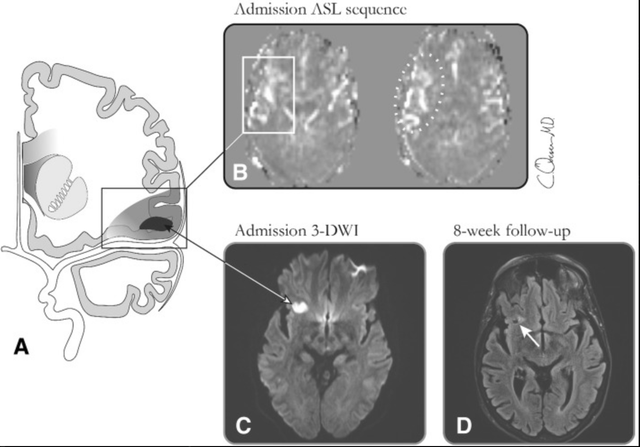

In [11]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [12]:
url = "http://localhost:80/v1/chat/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1,
}

response = get_completion_response(url, payload)
print(response)

Panel D illustrates the **8-week follow-up** MRI scan, which shows a **chronic infarct** with gliosis and encephalomalacia (tissue loss) in the region of the original stroke. This is consistent with the **infarct core**, which is the area of irreversibly damaged brain tissue.

The **infarct core** is typically identified on diffusion-weighted imaging (DWI) as a region of restricted diffusion (bright on DWI, dark on ADC maps), which is seen in **Panel C** (Admission 3-DWI). Over time, as seen in **Panel D**, the acute changes evolve into a chronic infarct with volume loss and gliosis.

Therefore, the correct answer is:

**A: The infarct core.**


### Image + Text Inference (Offline)

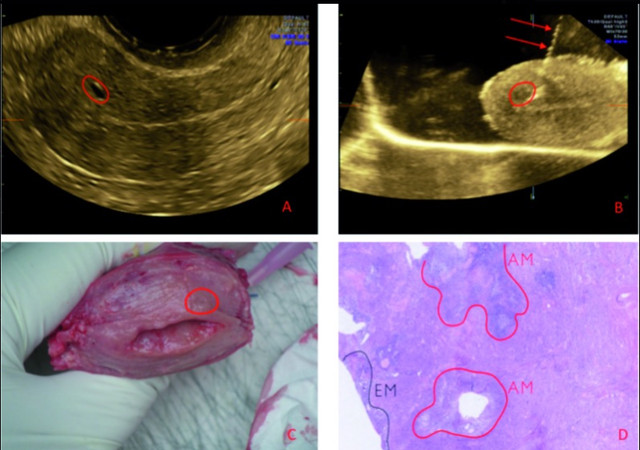

In [13]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [14]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [15]:
url = "http://localhost:80/v1/chat/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1,
}

response = get_completion_response(url, payload)
print(response)

Image D shows a histological section of uterine tissue, likely from a biopsy or surgical specimen. The key features visible in this image include:

- **Microcystic glands**: These are small, cyst-like structures lined by epithelial cells, which are characteristic of certain benign or pathological conditions of the endometrium.
- **Stromal tissue**: The surrounding pinkish matrix represents the connective tissue (stroma) of the uterus.
- **Labeling**: The image includes annotations such as "AM" (likely indicating the myometrium or muscular layer) and "EM" (possibly referring to the endometrial layer).

Given the presence of microcystic glands and the context of the other images (which include ultrasound and gross pathology), **Image D most accurately depicts the microcystic glands of the uterus**.

### Correct Answer:
**C: The microcystic glands of the uterus**


# Streaming Responses

In [16]:
def stream_response(url, payload):
    """
    Handles streaming responses from both `/v1/chat/completions` and `/v1/completions`.

    Args:
        url (str): The API endpoint URL.
        payload (dict): The JSON payload for the request.

    Prints the reconstructed streamed output in real-time.
    """
    response = requests.post(url, json=payload, stream=True)

    for chunk in response.iter_lines():
        if chunk:
            decoded = chunk.decode("utf-8")
            if decoded.startswith("data: "):
                data = decoded[len("data: "):]
                if data.strip() == "[DONE]":
                    break
                try:
                    parsed = json.loads(data)
                    choices = parsed.get("choices", [])
                    if not choices:
                        continue
                    choice = choices[0]

                    content = choice.get("delta", {}).get("content") or choice.get("text")
                    if content:
                        print(content, end="", flush=True)
                except (KeyError, json.JSONDecodeError):
                    continue


### Chat completions

In [17]:
url = "http://localhost:80/v1/chat/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
    "stream": True
}

stream_response(url, payload)

**Clinical Scenario Summary:**
- A 23-year-old pregnant woman at **22 weeks gestation** presents with **burning upon ur

ination** (dysuria) for 1 day, worsening despite hydration and cranberry extract.
- She is otherwise well, with **no systemic symptoms** (e.g., fever, flank pain).
- Vital signs are normal.
- **No costovertebral angle tenderness** → no evidence of pyelonephritis.
- Physical exam shows a **gravid uterus**.
- Suspected diagnosis: **Uncomplicated urinary tract infection (UTI)**, most likely **cystitis**.

---

### **Key Considerations in Pregnancy:**
- UTIs are common in pregnancy due to hormonal and anatomical changes (e.g., ureteral dilation, reduced bladder tone).
- Untreated UTIs can progress to **pyelonephritis**, which increases risk of preterm labor and other complications.
- Treatment should be **safe in pregnancy**, effective against common uropathogens (e.g., *E. coli*), and avoid teratogenic or fetal risks.

---

### **Evaluation of Options:**

**A: Ampicillin**  
- **Safe in pregnancy** (FDA category B).
- Effective against many *E. coli* strains, but resistance is common.
- *

### Text completions

In [18]:
url = "http://localhost:80/v1/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "prompt": f"{system_prompt}\n\nUser: {prompt2}\n\nAssistant:",
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
    "stream": True
}

stream_response(url, payload)

 # What to Do If You Have a Fever and Body Aches

Fever and body aches are common symptoms that can be caused by a variety of

 conditions, including viral infections (such as influenza or COVID-19), bacterial infections, or other inflammatory conditions. While these symptoms are often mild and resolve on their own, it's important to take appropriate steps to manage discomfort and monitor for signs of worsening illness.

## 1. **Assess the Severity of Symptoms**

Before taking action, evaluate the severity and duration of your symptoms:

- **Mild symptoms**: Low-grade fever (under 101°F or 38.3°C), mild body aches, and no other serious symptoms may be managed at home.
- **Severe symptoms**: High fever (over 103°F or 39.4°C), persistent body aches, difficulty breathing, chest pain, confusion, or rash require immediate medical attention.

## 2. **Monitor Your Temperature and Symptoms**

- Use a digital thermometer to check your temperature regularly.
- Keep a symptom diary noting fever patterns, pain location, and any new symptoms (e.g., cough, shortness of breath, sore throat).
- Watch for signs of dehydration 

### Image + Text Inference (Online)

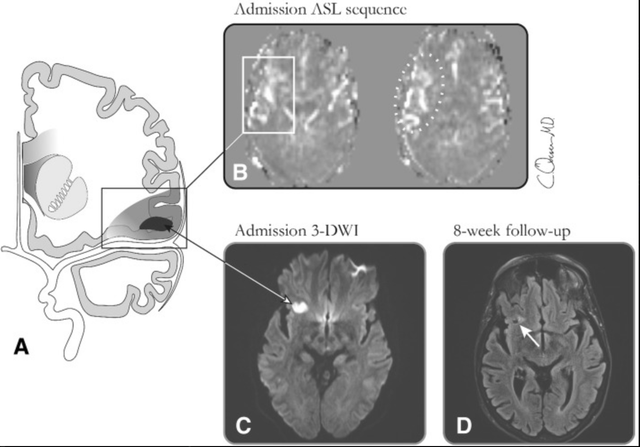

In [19]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [ ]:
url = "http://localhost:80/v1/chat/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1,
    "stream": True
}


stream_response(url, payload)

Panel D illustrates the **8-week follow-up** MRI scan, which shows a **chronic infarct** in the brain. The arrow points to a region of **gliosis and encephalomalacia** (brain tissue loss) that is characteristic of a healed stroke.

Let’s analyze the options:

- **A: The infarct core** – This refers to the central area of irreversibly damaged brain tissue, typically seen on diffusion-weighted imaging (DWI) at the time of stroke. This is shown in **Panel C**, not D.
- **B: The penumbra zone** – This is the area surrounding the infarct core that is ischemic but potentially salvageable. It is usually identified on perfusion imaging (like ASL or PWI) at admission, not on follow-up scans.
- **C: The arterial spin labeling lesion** – This would refer to a lesion seen on ASL imaging, which is shown in **Panel B**.
- **D: The ASL perfusion restriction** – This refers to reduced blood flow seen on ASL, which is also shown in **Panel B**.

**Panel D** is a follow-up scan showing **tissue loss** f

### Image + Text Inference (Offline)

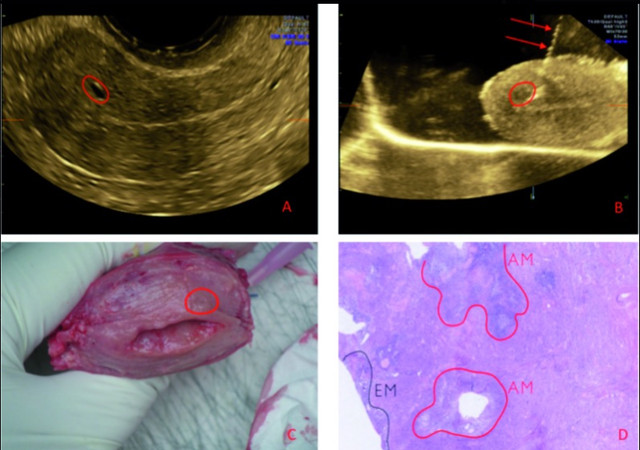

In [21]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [22]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [ ]:
url = "http://localhost:80/v1/chat/completions"

payload = {
    "model": "Medical-Visual-LLM-30B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1,
    "stream": True
}

stream_response(url, payload)

Image D shows a histological section of uterine tissue, likely from a biopsy or surgical specimen. The red outlines highlight structures that appear to be gland

ular formations within the tissue. The labels "AM" and "EM" are visible, which likely stand for **Amnion** and **Endometrium**, respectively.

Looking at the structures within the red circles:
- The glands are irregularly shaped and appear to be lined by epithelial cells.
- The surrounding stroma is pink and appears to be connective tissue.
- The presence of these glandular structures within the endometrial tissue is consistent with **microcystic glands**.

Given the options:
- **A: Normal uterus tissue** – While this could be part of normal tissue, the specific features shown (microcystic glands) suggest a more specific pathology.
- **B: The needle-marked zone of the uterus** – This would show trauma or artifact from a biopsy, which is not evident here.
- **C: The microcystic glands of the uterus** – This matches the appearance of the glandular structures in the image.
- **D: The endometrium** – While the tissue is part of the endometrium, this option is too broad and does not specifi


## Additional Endpoints  
You can access other API routes depending on the model's capabilities. Check your server startup logs for supported tasks and their corresponding endpoints.

The full list of available routes is logged during service initialization.